# Statistical Modelling
### Linear Regression (base model), Random Forest
1. Feature Selection
2. Use 2022 April as Test Data
3. Modelling
4. Hyper Parameter Tuning

In [1]:
from pyspark.sql.functions import to_timestamp, date_format, hour, dayofweek
from pyspark.sql.functions import isnan, when, count, col, split, concat, lit
from pyspark.sql.functions import to_date, create_map
from itertools import chain
from pyspark.sql import SparkSession, Window, functions as F
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
from datetime import datetime
import folium
import matplotlib.pyplot as plt
%matplotlib inline

# statistical model
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from statsmodels.formula.api import ols, glm
from sklearn import metrics
from sklearn.model_selection import cross_val_score


import warnings
warnings.filterwarnings("ignore")

In [2]:
# train data 2018-2019
df = pd.read_parquet("../data/curated/merged_df.parquet")
df['pu_date'] = pd.to_datetime(df['pu_date'])
df = df.sort_values(by=['pu_date', 'pu_hour']).reset_index(drop=True)

df['pu_day'] = df['pu_date'].dt.day
df['pu_month'] = df['pu_date'].dt.month
df.drop('pu_date', axis=1, inplace=True)

# test data Jan 2020
df_test = pd.read_parquet("../data/curated/merged_test_df.parquet")
df_test['pu_date'] = pd.to_datetime(df_test['pu_date'])
df_test = df_test.sort_values(by=['pu_date', 'pu_hour']).reset_index(drop=True)

df_test['pu_day'] = df_test['pu_date'].dt.day
df_test['pu_month'] = df_test['pu_date'].dt.month
df_test.drop('pu_date', axis=1, inplace=True)

---
## Standardize Data

In [3]:
df.head()

,pu_hour,pu_dow,is_school_holiday,trip_freq,temperature,dew_point,precipitation,wind_direction,visibility,pressure,pu_day,pu_month
0,0,2,1,240,-114.3,-200.300000,0.0,315.000000,16046.5,10260.5,1,1
1,1,2,1,141,-117.5,-206.500000,0.0,330.000000,16093.0,10262.0,1,1
2,2,2,1,33,-122.5,-200.500000,0.0,310.000000,16093.0,10262.0,1,1
3,3,2,1,26,-122.3,-197.300000,0.0,310.000000,16046.5,10262.5,1,1
4,4,2,1,50,-124.5,-198.233333,0.0,316.666667,16093.0,10262.0,1,1


In [4]:
std_col = ['temperature', 'dew_point', 'precipitation', 
           'wind_direction', 'visibility', 'pressure']
df_standard = df[std_col].astype(float).apply(zscore)

df_test_standard = df_test[std_col].astype(float).apply(zscore)

In [5]:
df_test_standard.shape

(744, 6)

In [6]:
df_standard.shape

(17518, 6)

In [7]:
df_standard.describe().loc[['mean','std']]

,temperature,dew_point,precipitation,wind_direction,visibility,pressure
mean,4.964823e-16,-6.691822e-16,-4.015543e-16,-6.655729e-16,1.995017e-16,-5.256213e-15
std,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00


In [8]:
df_standard.head()

,temperature,dew_point,precipitation,wind_direction,visibility,pressure
0,-2.482008,-2.431581,-0.213048,1.203785,0.373931,1.119520
1,-2.515051,-2.486621,-0.213048,1.355128,0.386613,1.137956
2,-2.566679,-2.433356,-0.213048,1.153337,0.386613,1.137956
3,-2.564614,-2.404948,-0.213048,1.153337,0.373931,1.144101
4,-2.587330,-2.413234,-0.213048,1.220601,0.386613,1.137956


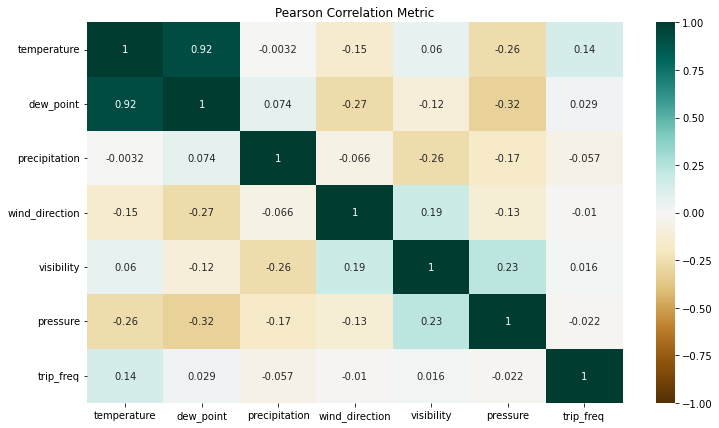

In [9]:
plt.figure(figsize=(12,7))
sns.heatmap(pd.concat([df_standard, df[['trip_freq']]], axis=1).corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')

plt.title('Pearson Correlation Metric')
plt.show()

In [10]:
df_fit = pd.concat([df_standard, df[['trip_freq']]], axis=1)
# let's try another model with all weather features
fit = ols(
    formula="trip_freq ~ temperature + dew_point + precipitation + wind_direction + visibility + pressure",
    data=df_fit
).fit()

In [11]:
# let's try another model without dew_point
fitter = ols(
    formula="trip_freq ~ temperature + precipitation + wind_direction + visibility + pressure",
    data=df_fit
).fit()

In [12]:
# let's try another model without temperature
fitter1 = ols(
    formula="trip_freq ~ dew_point + precipitation + wind_direction + visibility + pressure",
    data=df_fit
).fit()

In [13]:
fit.aic, fitter.aic, fitter1.aic

(252980.61726486217, 254391.3041391059, 254699.9893976533)

As Temperature and Dew point are very highly correlated, it is as expected that we should remove one of them to minimise complexity in the model. Using the AIC score, it is obvious that the model without dew_point has the lowest AIC. Hence, moving forward we will remove this feature.


In [14]:
valid_col = ["temperature", "precipitation", "wind_direction", "visibility", "pressure"]
df_standard = df_standard[valid_col]
df_test_standard = df_test_standard[valid_col]

---
## One-hot encode categorical variable

In [15]:
x_col = ['pu_hour', 'pu_dow', 'pu_day', 'pu_month']

enc = pd.get_dummies(df['pu_hour'], prefix='pu_hour')
for feature in x_col[1:]:
    df_feat = pd.get_dummies(df[feature], prefix=feature)
    enc = pd.concat([enc, df_feat], axis=1)

test_enc = pd.get_dummies(df_test['pu_hour'], prefix='pu_hour')
for feature in x_col[1:]:
    df_feat = pd.get_dummies(df_test[feature], prefix=feature)
    test_enc = pd.concat([test_enc, df_feat], axis=1)
for m in range(2, 13):
    test_enc[f'pu_month_{str(m)}'] = 0


In [16]:
enc.shape

(17518, 74)

In [17]:
test_enc.shape

(744, 74)

---
### Combine the standardized continuous features and one-hot encoded ordinal features into one dataframe

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17518 entries, 0 to 17517
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pu_hour            17518 non-null  int32  
 1   pu_dow             17518 non-null  int32  
 2   is_school_holiday  17518 non-null  int32  
 3   trip_freq          17518 non-null  int64  
 4   temperature        17518 non-null  float64
 5   dew_point          17518 non-null  float64
 6   precipitation      17518 non-null  float64
 7   wind_direction     17518 non-null  float64
 8   visibility         17518 non-null  float64
 9   pressure           17518 non-null  float64
 10  pu_day             17518 non-null  int64  
 11  pu_month           17518 non-null  int64  
dtypes: float64(6), int32(3), int64(3)
memory usage: 1.4 MB


In [21]:
X_train = pd.concat([df_standard, enc, df[['is_school_holiday']]], axis=1)
X_test = pd.concat([df_test_standard, test_enc, df_test[['is_school_holiday']]]
                   , axis=1)

In [22]:
X_train.shape, X_test.shape

((17518, 80), (744, 80))

In [23]:
scaler_y_train = StandardScaler().fit(df[['trip_freq']])
y_train = np.ravel(scaler_y_train.transform(df[['trip_freq']]))

scaler_y_test = StandardScaler().fit(df_test[['trip_freq']])
y_test = np.ravel(scaler_y_test.transform(df_test[['trip_freq']]))


---
# Linear Regression (base model)

In [24]:
from sklearn.linear_model import Ridge

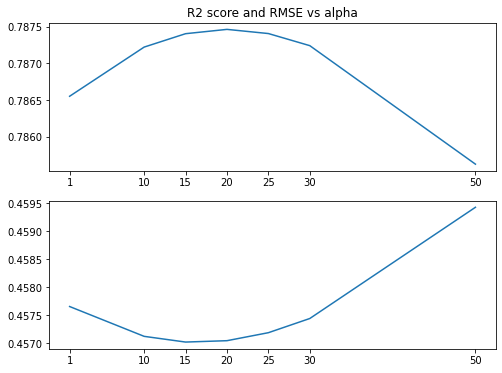

In [25]:
rmse = []
r2 = []
alphas = [1, 10, 15, 20, 25, 30, 50]
for a in alphas:
    ridge = Ridge(alpha=a).fit(X_train, y_train)
    rmse_cv = cross_val_score(ridge, X_train, y_train, cv=5, 
                             scoring='neg_root_mean_squared_error')
    rmse.append(abs(np.mean(rmse_cv)))
    
    r2_cv = cross_val_score(ridge, X_train, y_train, cv=5, scoring='r2')
    r2.append(np.mean(r2_cv))


plt.figure(figsize=(8,6))
plt.subplot(2, 1, 1)
plt.plot(alphas, r2, label='R2')
plt.xticks(alphas)
plt.title('R2 score and RMSE vs alpha')

plt.subplot(2, 1, 2)
plt.plot(alphas, rmse, label='RMSE')
plt.xticks(alphas)
plt.show()

When alpha=15, RMSE is at the lowest. So we choose alpha to be 15. Although R2-score is higher when alpha=2, RMSE is a more important metrics for demand estimation.

In [26]:
ridge = Ridge(alpha=15).fit(X_train, y_train)

In [29]:
y_pred = ridge.predict(X_test)

In [30]:
y_pred_actual = np.ravel(scaler_y_test.inverse_transform([y_pred]))

In [31]:
print('Root Mean Squared Error:', 
      np.sqrt(metrics.mean_squared_error(df_test['trip_freq'], y_pred_actual)),
      'trips.')
print('Root Mean Absolute Error:', 
      metrics.mean_absolute_error(df_test['trip_freq'],y_pred_actual),
      'trips.')

print('R^2 Score:', metrics.r2_score(df_test['trip_freq'], y_pred_actual))

Root Mean Squared Error: 101.37327599045022 trips.
Root Mean Absolute Error: 76.37625746358692 trips.
R^2 Score: 0.8609203099714196


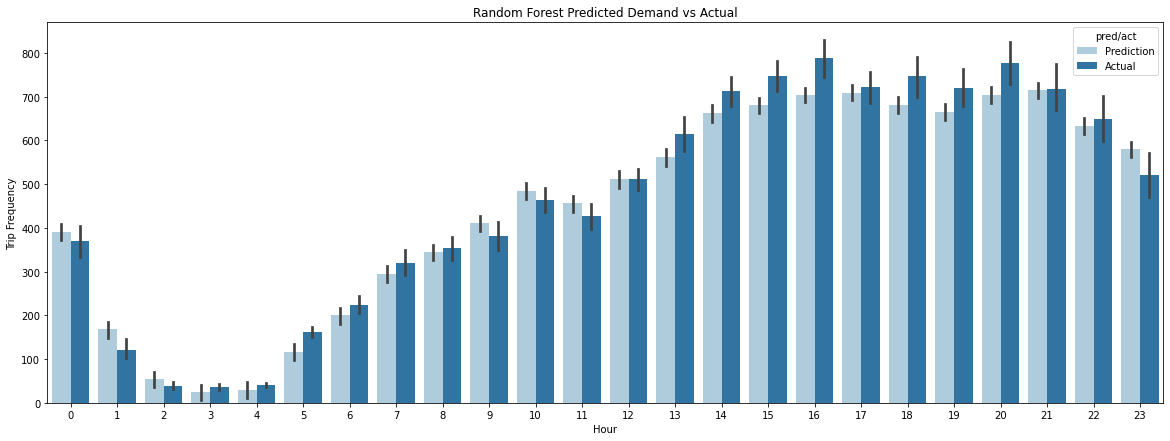

In [32]:
df1 = pd.DataFrame({'trip_freq':y_pred_actual})
df1['pu_hour'] = df_test['pu_hour']
df1['pu_day'] = df_test['pu_day']
df1['pred/act'] = 'Prediction'

df2 = df_test[['pu_hour', 'pu_day', 'trip_freq']]
df2['pred/act'] = 'Actual'

df_visualise = pd.concat([df1, df2],axis=0)

plt.figure(figsize=(20, 7))
sns.barplot(
    x="pu_hour", y="trip_freq", hue="pred/act", data=df_visualise, ci=95, 
    palette="Paired"
)
plt.xlabel("Hour")
plt.ylabel("Trip Frequency")
plt.title("Random Forest Predicted Demand vs Actual")
plt.show()



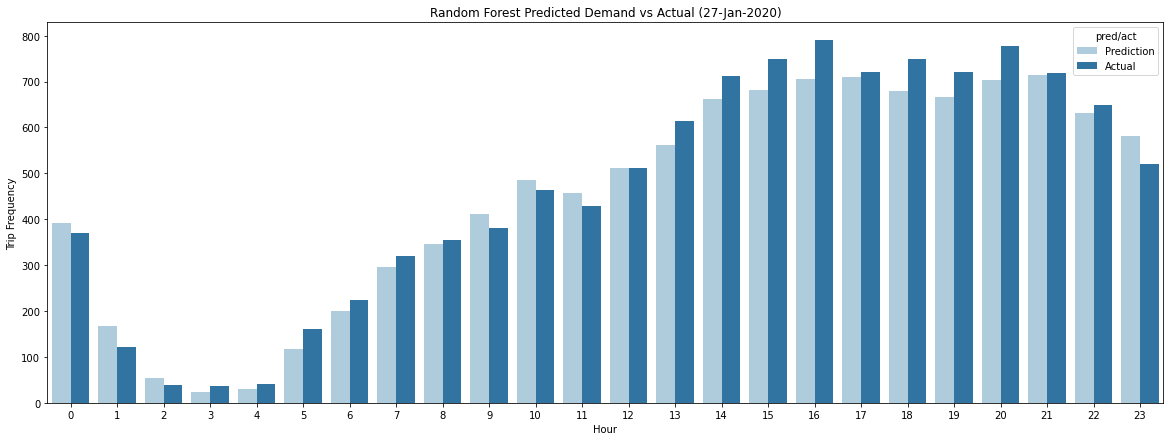

In [33]:

# look at 1 specific day 27 Jan 2020
df27 = df1[df1['pu_day'] == 27]
df27 = df2[df2['pu_day'] == 27]

df_visualise_27 = pd.concat([df1, df2],axis=0)

plt.figure(figsize=(20, 7))
sns.barplot(
    x="pu_hour", y="trip_freq", hue="pred/act", data=df_visualise_27, ci=None, 
    palette="Paired"
)
plt.xlabel("Hour")
plt.ylabel("Trip Frequency")
plt.title("Random Forest Predicted Demand vs Actual (27-Jan-2020)")
plt.show()



It is evident that the model is struggling to estimate demand during dawn time (3-4 am), but this is a good enough base model.

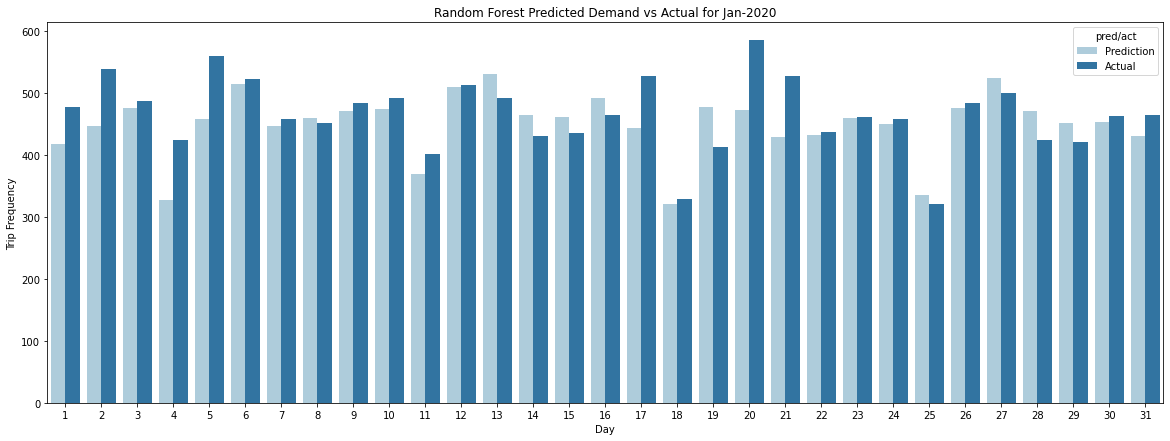

In [34]:
plt.figure(figsize=(20,7))
sns.barplot(
    x="pu_day", y="trip_freq", hue="pred/act", data=df_visualise, ci=None,
    palette="Paired"
)
plt.xlabel("Day")
plt.ylabel("Trip Frequency")
plt.title("Random Forest Predicted Demand vs Actual for Jan-2020")
plt.show()

---
# Random Forest Modelling
Use Random Forest as it is able to capture complex decision boundaries relationship between features.

### Hyperparameter Tuning (max_feature and n_estimator)

In [38]:
for mf in ("sqrt", "log2", 10, 15, None):
    rf = RandomForestRegressor(random_state = 42, max_features=mf)
    rmse_cv = cross_val_score(rf, X_train, y_train, cv=5, 
                             scoring='neg_root_mean_squared_error')
    r2_cv = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
    print(f"max_features = {mf}: \t", 'R2-score:', np.mean(r2_cv), 
          '\tRMSE:', abs(np.mean(rmse_cv)))

max_features = sqrt: 	 R2-score: 0.8297925493735934 	RMSE: 0.4095093927369489
max_features = log2: 	 R2-score: 0.8238667661334537 	RMSE: 0.41695693315671417
max_features = 10: 	 R2-score: 0.8301291501151784 	RMSE: 0.4086421293788248
max_features = 15: 	 R2-score: 0.8280924620744934 	RMSE: 0.4105036576124218
max_features = None: 	 R2-score: 0.8121274773129613 	RMSE: 0.4277162378854483


In [39]:
rmse = []
r2 = []
for mf in (8, 9, 10, 11, 12):
    rf = RandomForestRegressor(random_state = 42, max_features=mf)
    rmse_cv = cross_val_score(rf, X_train, y_train, cv=5, 
                             scoring='neg_root_mean_squared_error')
    rmse.append(abs(np.mean(rmse_cv)))
    
    r2_cv = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
    r2.append(np.mean(r2_cv))
#     print(f"max_features = {mf}: \t", 'R2-score:', np.mean(r2_cv), 
#           '\tRMSE:', abs(np.mean(rmse_cv)))


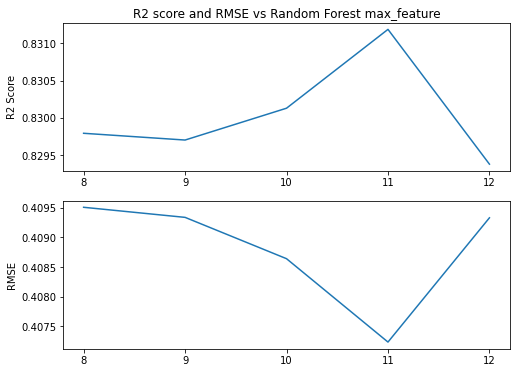

In [46]:
mfs = (8, 9, 10, 11, 12)
plt.figure(figsize=(8,6))
plt.subplot(2, 1, 1)
plt.plot(range(len(mfs)), r2, label='R2')
plt.xticks(range(len(mfs)), mfs)
plt.ylabel('R2 Score')
plt.title('R2 score and RMSE vs Random Forest max_feature')

plt.subplot(2, 1, 2)
plt.plot(range(len(mfs)), rmse, label='RMSE')
plt.xticks(range(len(mfs)), mfs)
plt.ylabel('RMSE')
plt.show()

When max_feature = 11, the model has highest r2 score and lowest RMSE.

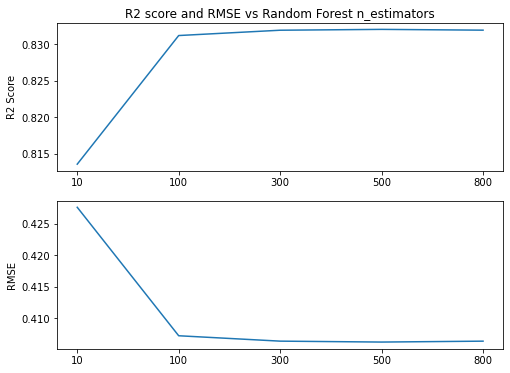

In [47]:
rmse = []
r2 = []
ests = (10, 100, 300, 500, 800)


for n_est in ests:
    rf = RandomForestRegressor(n_estimators=n_est, random_state = 42, 
                               max_features=11)
    rmse_cv = cross_val_score(rf, X_train, y_train, cv=5, 
                             scoring='neg_root_mean_squared_error')
    r2_cv = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
    
    rmse.append(abs(np.mean(rmse_cv)))
    r2.append(np.mean(r2_cv))
    
plt.figure(figsize=(8,6))
plt.subplot(2, 1, 1)
plt.plot(range(len(ests)), r2, label='R2')
plt.xticks(range(len(ests)), ests)
plt.ylabel('R2 Score')
plt.title('R2 score and RMSE vs Random Forest n_estimators')

plt.subplot(2, 1, 2)
plt.plot(range(len(ests)), rmse, label='RMSE')
plt.xticks(range(len(ests)), ests)
plt.ylabel('RMSE')
plt.show()

When n_estimators = 500, the model has best r2 score and lowest RMSE.

In [52]:
rf = RandomForestRegressor(n_estimators = 500, max_features=11, random_state = 42)
rf.fit(X_train, y_train)

RandomForestRegressor(max_features=11, n_estimators=500, random_state=42)

### Prediction and Evaluation

In [53]:
y_pred = rf.predict(X_test)

In [54]:
y_pred_actual = np.ravel(scaler_y_test.inverse_transform([y_pred]))

In [55]:
print('Root Mean Squared Error:', 
      np.sqrt(metrics.mean_squared_error(df_test['trip_freq'], y_pred_actual)),
      'trips.')
print('Root Mean Absolute Error:', 
      metrics.mean_absolute_error(df_test['trip_freq'],y_pred_actual),
      'trips.')
print('R^2 Score:', metrics.r2_score(df_test['trip_freq'], y_pred_actual))

Root Mean Squared Error: 94.70993657076701 trips.
Root Mean Absolute Error: 70.07657810830949 trips.
R^2 Score: 0.8786030312284154


### Prediction vs Actual Visualization

In [ ]:
df1 = pd.DataFrame({'trip_freq':y_pred_actual})
df1['pu_hour'] = df_test['pu_hour']
df1['pu_day'] = df_test['pu_day']
df1['pred/act'] = 'Prediction'

df2 = df_test[['pu_hour', 'pu_day', 'trip_freq']]
df2['pred/act'] = 'Actual'

df_visualise = pd.concat([df1, df2],axis=0)

plt.figure(figsize=(20, 7))
sns.barplot(
    x="pu_hour", y="trip_freq", hue="pred/act", data=df_visualise, ci=95, 
    palette="Paired"
)
plt.xlabel("Hour")
plt.ylabel("Trip Frequency")
plt.title("Random Forest Predicted Demand vs Actual")
plt.show()



Interestingly, the model is very optimistic during the morning peaks, and appears to have become more pessimistic after noon.

In [ ]:

# look at 1 specific day 27 Jan 2020
df27 = df1[df1['pu_day'] == 27]
df27 = df2[df2['pu_day'] == 27]

df_visualise_27 = pd.concat([df1, df2],axis=0)

plt.figure(figsize=(20, 7))
sns.barplot(
    x="pu_hour", y="trip_freq", hue="pred/act", data=df_visualise_27, ci=None, 
    palette="Paired"
)
plt.xlabel("Hour")
plt.ylabel("Trip Frequency")
plt.title("Random Forest Predicted Demand vs Actual (27-Jan-2020)")
plt.show()


This model estimation during 3-4 am matches the actual, unlike linear regression prediction

In [ ]:
plt.figure(figsize=(20,7))
sns.barplot(
    x="pu_day", y="trip_freq", hue="pred/act", data=df_visualise, ci=None,
    palette="Paired"
)
plt.xlabel("Day")
plt.ylabel("Trip Frequency")
plt.title("Random Forest Predicted Demand vs Actual for Jan-2020")
plt.show()

In [ ]:
# visualise feature importance value
importances = list(rf.feature_importances_)
df_imp = (pd.DataFrame({'feature':X_train.columns.tolist(), 'importances':importances})
            .sort_values(by='importances', ascending=False).reset_index(drop=True))

df_imp_top30 = df_imp[:30]
plt.figure(figsize=(15,5))
plt.bar('feature', 'importances', orientation = 'vertical', data=df_imp_top30)
plt.xticks(rotation=45, ha="right")
plt.xlabel("")
plt.ylabel("Importance Value")
plt.title("Most important feature for the Random Forest Model")
plt.show()